In [13]:
import torch
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
from torch import nn
from torch import optim
from progressbar import ProgressBar
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
matplotlib.style.use('ggplot')


# Cargar base de datos

In [101]:
direccion="C:/Users/andre/Desktop/Daniel .v/Semestre 2022-1/Seminario Estadística I/Proyectos-II/Admission_Predict.csv"
base=pd.read_csv(direccion)

# Objetivo de la red neuronal
En este notebook se busca aplicar redes neuronales en la base de datos "Graduate Admission 2" para realizar una regresión lineal que prediga cual es la probabilidad de una persona de ingresar a una universidad según varios factores y características del aspirante, como la calificación de diversos exámenes o algunas propiedades de las universidades

# Exploración de la base de datos
A continuación se explorará la base de datos, generando gráficas como histogramas,boxplots y usando comandos como describe() e info() , entre otros


In [48]:
base.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,115.614301,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,100.750000,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,200.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,300.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


La base reúne los siguientes datos de un determinado aspirante (según  https://www.kaggle.com/mohansacharya/graduate-admissions que fue el lugar donde se recopiló la base):\

-GRE Scores ( out of 340 )

-TOEFL Scores ( out of 120 )

-Statement of Purpose and Letter of Recommendation Strength ( out of 5 )

-Undergraduate GPA ( out of 10 )

-Research Experience ( either 0 or 1 )

Y de la universidad reúne:

-University Rating ( out of 5 )

-Chance of Admit ( ranging from 0 to 1 )

a continuación más exploración

In [49]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    int64  
 8   Chance of Admit    400 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [9]:
base.head()


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [10]:
base.tail()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91
398,399,312,103,3,3.5,4.0,8.78,0,0.67
399,400,333,117,4,5.0,4.0,9.66,1,0.95


In [31]:
nombres=['GRE Score','TOEFL Score','CGPA','Chance of Admit ']
base_nocategorica=base[nombres]
base_nocategorica.head()

,GRE Score,TOEFL Score,CGPA,Chance of Admit
0,337,118,9.65,0.92
1,324,107,8.87,0.76
2,316,104,8.00,0.72
3,322,110,8.67,0.80
4,314,103,8.21,0.65


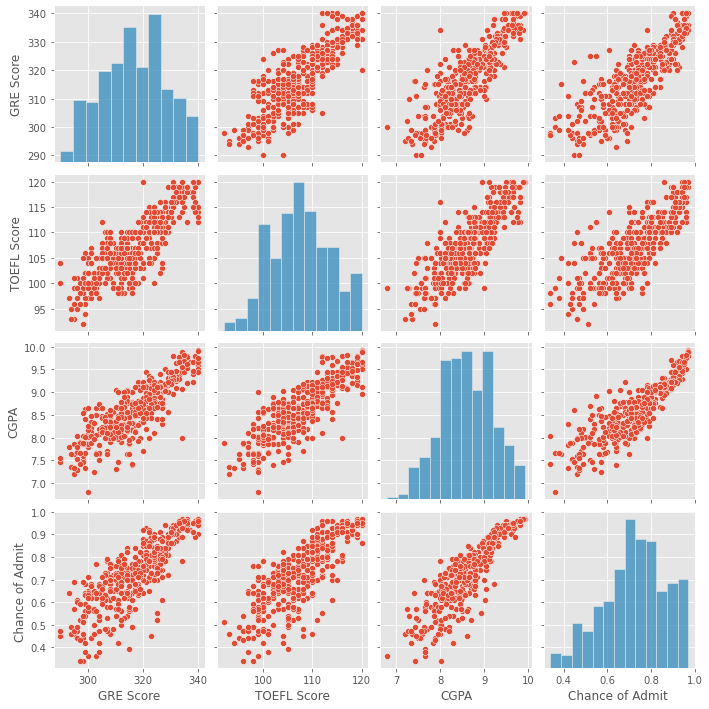

In [32]:
sns.pairplot(base_nocategorica)

<AxesSubplot:title={'center':'Chance of Admit '}, xlabel='[Research]'>

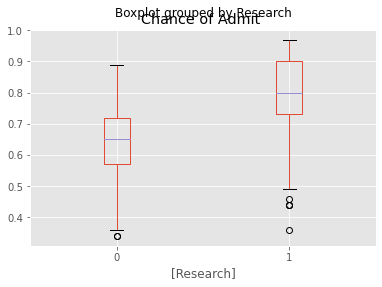

In [38]:
text='Research'
base[[text,'Chance of Admit ']].boxplot(by=text)

<AxesSubplot:title={'center':'Chance of Admit '}, xlabel='[University Rating]'>

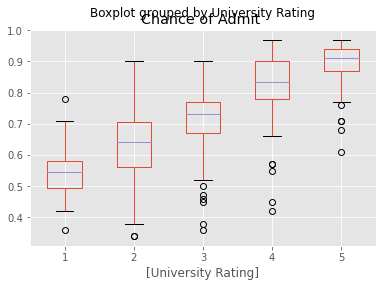

In [40]:
text='University Rating'
base[[text,'Chance of Admit ']].boxplot(by=text)

<AxesSubplot:title={'center':'Chance of Admit '}, xlabel='[SOP]'>

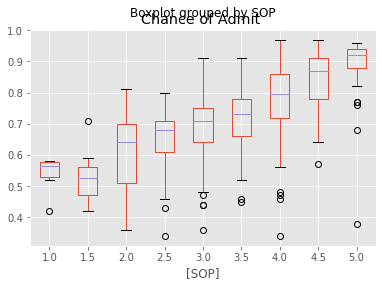

In [41]:
text='SOP'
base[[text,'Chance of Admit ']].boxplot(by=text)

<AxesSubplot:title={'center':'Chance of Admit '}, xlabel='[LOR ]'>

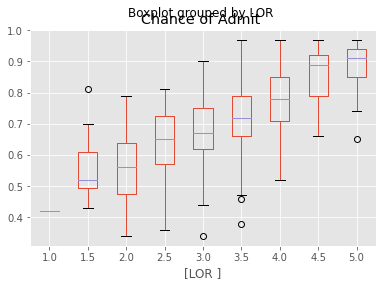

In [45]:
text='LOR '
base[[text,'Chance of Admit ']].boxplot(by=text)

# Normalización de los datos no categóricos. 

Aunque en un inicio no se planeaba usar la base de datos completa, en los diagramas boxplot podemos observar que en las variables categóricas, de fijarnos únicamente en las medias, hay una especie de relación lineal de todas las categorías con respecto a la variable de respuesta que queremos estudiar, que es Chance of Admit. Esto resulta en que se usen las variables categóricas sin ningún cambio.Por otro lado, aplicaremos una normalización de los datos no categóricos   


In [55]:
text='GRE Score'
mean=base[text].mean()
std=base[text].std()
base['Nor'+text] = base[text].apply(lambda x: (x - mean)/std)


In [56]:
text='TOEFL Score'
mean=base[text].mean()
std=base[text].std()
base['Nor'+text] = base[text].apply(lambda x: (x - mean)/std)


In [57]:
text='CGPA'
mean=base[text].mean()
std=base[text].std()
base['Nor'+text] = base[text].apply(lambda x: (x - mean)/std)

In [58]:
text='Chance of Admit '
mean=base[text].mean()
std=base[text].std()
base['Nor'+text] = base[text].apply(lambda x: (x - mean)/std)

# Diseño de base de datos 
En este caso se cuentan con muy pocos datos, por lo cual se buscara partir los datos en 60% entrenamiento, 40% test: 

In [85]:
msk = np.random.rand(len(base)) < 0.6
training_data = base[msk]
test_data = base[~msk]

Para poder usar mejor los datos alojados en la base de datos, se procederá instanciando a Dataset, creando una clase particular para el uso de este ejercicio: 


In [66]:
class DataFrameDataset(Dataset):
  def __init__(self, data, x_names:list, y_name):
    X = data[x_names]
    Y = data[y_name] # -> una columna del dataframe
    self.X = torch.from_numpy(X.to_numpy()).to(dtype=torch.float32)
    self.Y = torch.from_numpy(Y.to_numpy()).to(dtype=torch.float32)

  def __len__(self):
    return self.Y.size()[0]

  def __getitem__(self, idx):
    x = self.X[idx, :]
    y = self.Y[idx]
    return x, y


In [90]:
train_set = DataFrameDataset(training_data, ['NorGRE Score','NorTOEFL Score','NorCGPA','Research','University Rating','SOP','LOR '], ['Chance of Admit '])
test_dataset=DataFrameDataset(test_data, ['NorGRE Score','NorTOEFL Score','NorCGPA','Research','University Rating','SOP','LOR '], ['Chance of Admit '])


Ahora partiremos los datos de test  en 60% validación y 40% test para poder evaluar nuestro modelo en cada epoch:


In [91]:
msk = np.random.rand(len(test_dataset)) < 0.6
val_set = torch.utils.data.Subset(test_dataset, np.where(msk)[0])
test_set = torch.utils.data.Subset(test_dataset, np.where(~msk)[0])

Obtenemos el largo de cada uno de los conjuntos de datos: 

In [92]:
n_train = len(train_set)
n_val = len(val_set)
n_test = len(test_set)


# Dataloader

Se parten los datos en mini batches, de acuerdo a lo que se debe de hacer para poder usar los algoritmos de redes neuronales. Pero, al ser tan pocos datos los mini-batches serán de tamaño 1:

In [93]:
batch_size = 1
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=n_test)

# Declaración del modelo lineal

Se logra heredando de nn.Module

In [94]:
class LinearNet(nn.Module):
  def __init__(self,n_in, n_out):
    super(LinearNet, self).__init__()
    self.layer = nn.Linear(in_features=n_in, out_features=n_out, bias=True)
    self.in_features = n_in

  def forward(self, x):
    out = self.layer(x)
    return out
model=LinearNet(7,1)

# Función objetivo y optimizador: 
Para poder mejorar los parámetros

In [95]:
cost = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0, nesterov=False)

# Entrenamiento del modelo:
A continuación, se entrena y evalúa el modelo, apoyándonos de herramientas gráficas

In [96]:
def update_parameters(model, dataloader, optimizer, criterion, train=True):
  running_loss = 0.0
  for i, data in enumerate(dataloader, 0):
    X, Y = data
    n = len(X)
    X = X.reshape((n, model.in_features)) # -> Corrección de tamaño, sólo es necesario en dim=1
    m = len(Y)
    Y = Y.reshape((m, 1)) # -> Corrección de tamaño
    if train:
      optimizer.zero_grad() # reinicia el gradiente
    pred = model(X) # forward pass 
    loss = criterion(pred, Y) # evaluación de predicción
    if train:
      loss.backward() # cálcula las derivadas 
      optimizer.step() # paso de optimización 

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
  return avg_loss

In [97]:
def train(model, train_loader, optimizer, criterion, epochs=100, val_loader=None, val=False):
  plt.figure(figsize=(20,8))
  plt.subplot(1, 2, 1)
  plt.title('Weight vs Height', size=24)
  plt.xlabel('Height')
  plt.xlabel('Weight')
  D_train = np.array(train_dataloader.dataset)
  X = D_train[:, 0]; Y = D_train[:, 1]
  plt.scatter(X, Y, alpha=0.1)
  if val:
    D_val = np.array(val_dataloader.dataset)
    X_ = D_val[:, 0]; Y_ = D_val[:, 1]
    plt.scatter(X_, Y_, alpha=0.2)

  w = float(model.layer.weight.detach().squeeze())
  b = float(model.layer.bias.detach().squeeze())
  plt.plot(X, w*X+b, color='green', lw=1)
  train_losses = list(); val_losses = list()
  bar = ProgressBar(max_value=epochs)
  alpha=0.1

  for epoch in range(epochs):
    train_loss = update_parameters(model, train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)
    if val:
      val_loss = update_parameters(model, val_dataloader, None, criterion, train=False)
      val_losses.append(val_loss)

    w = float(model.layer.weight.detach().squeeze())
    b = float(model.layer.bias.detach().squeeze())
    if epoch == epochs-1:
      alpha=0.7
    plt.plot(X, w*X+b, alpha=alpha)
    bar.update(epoch)

  plt.subplot(1, 2, 2)
  plt.plot(train_losses)
  if val:
    plt.plot(val_losses)
    plt.legend(['train', 'val'], loc='upper right')
  plt.title('Cost vs epoch', size=24)
  plt.xlabel('epoch', size=18)
  plt.ylabel('cost', size=18)
  return train_losses, val_losses

In [98]:
epoch_loss = list()
val_loss = list()
epochs = 100

for epoch in range(epochs):
  loss_train = update_parameters(model, train_dataloader, optimizer, cost)
  loss_val = update_parameters(model, val_dataloader, None, cost, train=False)
  epoch_loss.append(loss_train)
  val_loss.append(loss_val)
  if epoch % 5 == 0:
    print('epoch {}, train loss {}, val loss {}'.format(epoch, loss_train, loss_val))

epoch 0, train loss 0.0996830889834763, val loss 0.04424400670184188
epoch 5, train loss 0.01729839863422467, val loss 0.01156381108316868
epoch 10, train loss 0.009656360630767667, val loss 0.011705286524900039
epoch 15, train loss 0.007657633522378575, val loss 0.004814312568428121
epoch 20, train loss 0.007581801614640526, val loss 0.008510735191352462
epoch 25, train loss 0.007934260257643962, val loss 0.005114892212530163
epoch 30, train loss 0.007062971081256807, val loss 0.004153881524022845
epoch 35, train loss 0.007640113255626401, val loss 0.007038714124683258
epoch 40, train loss 0.007030616372299653, val loss 0.004032777294877722
epoch 45, train loss 0.006900253042711186, val loss 0.0041879894701965315
epoch 50, train loss 0.0067982076993798385, val loss 0.004547451511347596
epoch 55, train loss 0.006774248145560468, val loss 0.00886931059668998
epoch 60, train loss 0.00730257235154761, val loss 0.04049667907549834
epoch 65, train loss 0.007468400080735991, val loss 0.00454

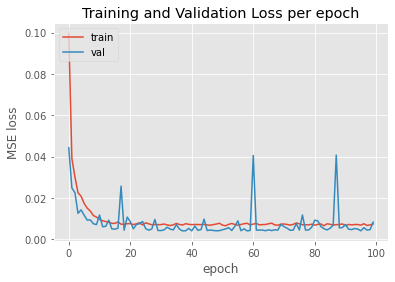

In [99]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss per epoch')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [100]:
data = next(iter(test_dataloader))
X, Y = data
n = len(Y)
Y = Y.reshape((n, 1)) # -> Corrección de tamaño
pred = model(X)
error = cost(Y, pred)
print('error de prueba :{}'.format(error.item()))

error de prueba :0.008908030577003956
